<h1>Assignment 1 Notebook</h1>

<p>This notebook is meant to serve as a sort of in-depth README file for this assignment (because I haven't bothered to make a README yet and I like Jupyter Notebooks a bit better personally. I'll go through everything I do in our class to create the convolution object that we will be messing with for this assignment as well as create some basic templates for images and other important functions for deep learning with PyTorch.</p>

<h3>Imports</h3>

In [12]:
import time
import math

import numpy as np
import matplotlib.pyplot as plt

import torch
import torchvision

import PIL

%matplotlib inline

<h3>Image Loading</h3>

<p>We're gonna create a function that just takes an image path and then returns both a black and white and a colored version of the image after displaying the image.</p>

In [13]:
def get_image(filepath):
    original_image = PIL.Image.open(filepath)
    black_and_white = original_image.convert('L')
    
    fig = plt.figure(figsize=(10,10))
    fig.add_subplot(121)
    plt.imshow(original_image)
    plt.title('Original Loaded Image')
    plt.axis('off')
    
    fig.add_subplot(122)
    plt.imshow(black_and_white)
    plt.title('Black and White Image')
    plt.axis('off')
   
    plt.show()
    
    return [original_image, black_and_white]

<h3>Class Creation</h3>

<p>This is where we'll create the actual Conv2D class so that other files can call the convolution methods that we're defining here. That doesn't work exactly so in a Jupyter Notebook, but it's ok because we've got a main.py script calling a conv.py script class object in this same directory so you can check in that file if you'd like to see how to invoke the Conv2D object outside of a given script with an import statement.</p>

In [14]:
class Conv2D(object):

    def __init__(self, in_channel, o_channel, kernel_size, stride, mode):
        self.in_channel = in_channel
        self.o_channel = o_channel
        self.kernel_size = kernel_size
        self.stride = stride
        self.mode = mode

    def forward(self, input_image):

        # Set up kernels
        kernels = []

        K1 = torch.tensor([
            [-1, -1, -1], 
            [ 0, 0, 0], 
            [1, 1, 1]
        ])
        K2 = torch.tensor([
            [-1, 0, 1], 
            [-1, 0, 1], 
            [-1, 0, 1]
        ])
        K3 = torch.tensor([
            [1, 1, 1], 
            [1, 1, 1], 
            [1, 1, 1]
        ])
        K4 = torch.tensor([
            [-1, -1, -1, -1, -1], 
            [-1, -1, -1, -1, -1], 
            [0, 0, 0, 0, 0], 
            [1, 1, 1, 1, 1], 
            [1, 1, 1, 1, 1]
        ])
        K5 = torch.tensor([
            [-1, -1, 0, 1, 1], 
            [-1, -1, 0, 1, 1], 
            [-1, -1, 0, 1, 1], 
            [-1, -1, 0, 1, 1], 
            [-1, -1, 0, 1, 1]
        ])
        K6 = torch.tensor([
            [-1, -1, -1],
            [ 0,  0,  0], 
            [ 1,  1,  1]
        ])
        K7 = torch.tensor([
             [-1, -1, -1],
             [-1,  8, -1],  
             [-1, -1, -1]
        ])
        K8 = torch.tensor([
            [-1, 0, -1],
            [-2, 0,  2],
            [-1, 0,  1]
        ])
       
        num_kernels = self.o_channel

        if self.mode == 'rand':
            for i in range(0,num_kernels):
                kernels.append(torch.randint(-10, 10, (self.kernel_size,self.kernel_size)))
        elif self.mode == 'horizontal_edges':
            for i in range(0,num_kernels):
                kernels.append(K1)
        elif self.mode == 'vertical_edges':
            for i in range(0,num_kernels):
                kernels.append(K2)
        elif self.mode == 'edges':
            for i in range(0,num_kernels):
                kernels.append(K7)
            

        # Convert image object to tensor
        image_array = np.array(input_image)
        image_tensor = torch.from_numpy(image_array)
        dimensions_list = list(image_tensor.shape)
       
        padding = int((self.kernel_size) / 2)

        if self.in_channel > 1:
            padded_tensor = torch.zeros(dimensions_list[0] + padding, dimensions_list[1] + padding, dimensions_list[2])
            padded_tensor[1:dimensions_list[0]+1, 1:dimensions_list[1]+1, :] = image_tensor
        else:
            padded_tensor = torch.zeros(dimensions_list[0] + padding, dimensions_list[1] + padding)
            padded_tensor[1:dimensions_list[0]+1, 1:dimensions_list[1]+1] = image_tensor

        num_rows = dimensions_list[0]
        num_cols = dimensions_list[1]

        output_rows = int((num_rows - self.kernel_size + 2*padding) / self.stride + 1)
        output_cols = int((num_cols - self.kernel_size + 2*padding) / self.stride + 1)

        print("Input image resolution: %dx%d.\n" % (num_rows, num_cols), end="", flush=True)

        # Setting up the output array
        output_tensors = [torch.zeros(output_rows, output_cols) for x in kernels]
        num_operations = [0 for x in kernels]

        for i in range(0,num_kernels):
            print("\nRandomly generated kernel: ")
            print(kernels[i])
            print("\nCurrent kernel number: %d" % (i+1))
            for channel in range(0,self.in_channel):
                print("Current input channel: %d" % (channel+1))
                half_kernel = math.floor(self.kernel_size / 2)
                # Iterate through each row of the image (outer loop -- y)
                row_out = 0
                for row in range(half_kernel, num_rows-half_kernel, self.stride):
                    # Iterate through each column of the image (inner loop -- x)
                    col_out = 0
                    for col in range(half_kernel, num_cols-half_kernel, self.stride): 
                        num_operations[i] = num_operations[i] + self.kernel_size + self.kernel_size-1

                        if self.in_channel > 1:
                            region_of_interest = padded_tensor[row-half_kernel:row+half_kernel+1, col-half_kernel:col+half_kernel+1, channel]    
                        else:
                            region_of_interest = padded_tensor[row-half_kernel:row+half_kernel+1, col-half_kernel:col+half_kernel+1]    
                        
                        region_of_interest = region_of_interest.double()
                        kernel = kernels[i].double()

                        output_tensors[i][row_out, col_out] = output_tensors[i][row_out, col_out] + torch.tensordot(region_of_interest, kernel)
                        
                        col_out = col_out + 1
                    row_out = row_out + 1

        output_tensors = [torch.clamp(output_tensor, min=0, max=255) for output_tensor in output_tensors]

        return [num_operations, output_tensors]

<h3>Class Invocation</h3>

<p>Here we'll get an image with our previously defined function and actually instantiate an object for the convolution class. To perform a convolution on it. Since the assignment main and conv files already show how to do each teask in the assignment I'd like to extend the functionality of the class a bit and make it so that a user can supply a list of possible image convolution methods and the class choose an appropriate kernel for that task. That means o_channel should always be 1 when invoking this class in this notebook.</p>

In [15]:
def tensors_to_images(tensors, conv2d, output_name):

    conv_result_images = []

    # Take the returned tensor convolution result and turn it into an image.
    # A user-defined function would be super useful for this but the instructions
    # don't mention any functions other than main being allowed for this file
    for i, tensor in enumerate(tensors):
        # Normalize the convolution output tensor to a 0-1 scale
        tensor = (tensor - torch.min(tensor)) / (torch.max(tensor) - torch.min(tensor))

        # Convert the tensor to a numpy array and then normalize to 0-255 scale
        numpy_result = tensor.numpy()
        numpy_result = numpy_result * 255

        # Convert the numpy array to a PIL image and then convert it to black and white
        conv_result_images[i] = PIL.Image.fromarray(numpy_result)
        conv_result_images[i] = conv_result_image.convert('RGB')

        # Save the resultant image as a png image file
        conv_result_image.save('results/'+output_name+'.png', 'PNG')
        print('Convolution image saved as results/'+output_name+'.png')
        plt.figure(figsize=(10,10))
        plt.imshow(conv_result_images[i])
        plt.axis('off')
        plt.title('Resultant Image')
    
    return conv_result_images

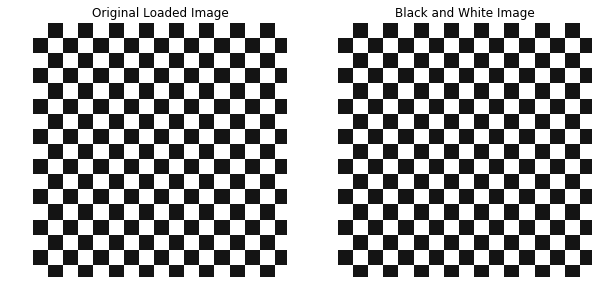

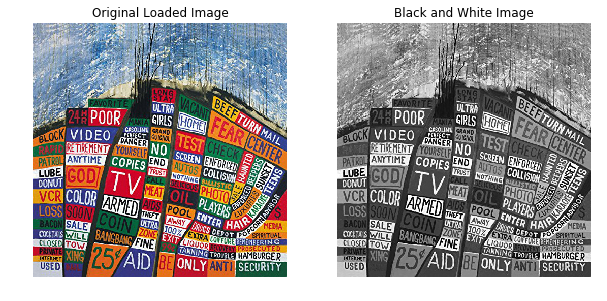

In [16]:
provided_path = 'images/checkerboard.png'
[checkerboard, checkerboard_bw] = get_image(provided_path)

personal_path = 'images/HTTT.jpg'
[thief, thief_bw] = get_image(personal_path)

In [17]:
mode = input('What mode of image convolution would you like to perform on your image?\n \
\nOptions: \nhorizontal_edges\nvertical_edges\nedges\nrand\n')

output_name = input('What would you like to name your resultant image (without extension)? ')

conv2d = Conv2D(
    in_channel=1,
    o_channel=1,
    kernel_size=3,
    stride=1,
    mode=mode
)

[num_operations, output_tensors] = conv2d.forward(checkerboard_bw)
result_images = tensors_to_images(output_tensors, conv2d, output_name)

What mode of image convolution would you like to perform on your image?
 
Options: 
horizontal_edges
vertical_edges
edges
rand
edges
What would you like to name your resultant image (without extension)? thief_edges
Input image resolution: 420x420.

Randomly generated kernel: 
tensor([[-1, -1, -1],
        [-1,  8, -1],
        [-1, -1, -1]])

Current kernel number: 1
Current input channel: 1
Convolution image saved as results/thief_edges.png
